In [32]:
import warnings

import numpy as np
import timecorr as tc
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.stats import wishart
import hypertools as hyp
from scipy.spatial.distance import cdist

%matplotlib inline

LEGEND_SIZE = 16
SMALL_SIZE = 18
MEDIUM_SIZE = 21
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
if not os.path.isdir('figs'):
    os.mkdir('figs')
figdir = 'figs'

In [5]:
def random_corrmat(K):
    x = np.random.randn(K, K)
    x = x * x.T
    x /= np.max(np.abs(x))
    np.fill_diagonal(x, 1.)
    return x

In [6]:
def ramping_dataset(K, T):
    warnings.simplefilter('ignore')
    def dist(a, b):
        return cdist(np.atleast_2d(a), np.atleast_2d(b), 'correlation')
    
    a = tc.mat2vec(random_corrmat(K))
    b = tc.mat2vec(random_corrmat(K))
    max_dist = dist(a, b)
    max_iter = 100
    for i in np.arange(max_iter):
        next_b = tc.mat2vec(random_corrmat(K))
        next_dist = dist(a, next_b)
        if next_dist > max_dist:
            b = next_b
            max_dist = next_dist
    
    mu = np.linspace(1, 0, T)
    
    corrs = np.zeros([T, int((K**2 - K)/2 + K)])
    Y = np.zeros([T, K])
    
    for t in np.arange(T):
        corrs[t, :] = mu[t]*a + (1 - mu[t])*b
        Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(corrs[t, :]))
    
    return Y, corrs

In [7]:
def random_dataset(K, T):
    warnings.simplefilter('ignore')
        
    corrs = np.zeros([T, int((K**2 - K)/2 + K)])
    Y = np.zeros([T, K])
    
    for t in np.arange(T):
        corrs[t, :] = tc.mat2vec(random_corrmat(K))
        Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(corrs[t, :]))
    
    return Y, corrs

In [8]:
B = 5 #number of blocks
def block_dataset(K, T):
    warnings.simplefilter('ignore')
    block_len = np.ceil(T / B)
    
    corrs = np.zeros([B, int((K**2 - K)/2 + K)])
    Y = np.zeros([T, K])
    
    for b in np.arange(B):
        corrs[b, :] = tc.mat2vec(random_corrmat(K))
    corrs = np.repeat(corrs, block_len, axis=0)
    corrs = corrs[:T, :]
    
    for t in np.arange(T):
        Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(corrs[t, :]))
    
    return Y, corrs

In [9]:
Y, corrs = block_dataset(100, 1000)

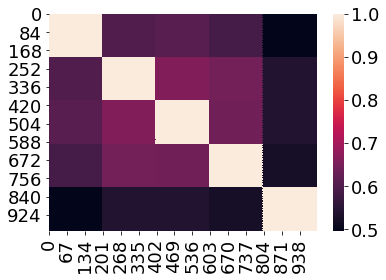

In [8]:
sns.heatmap(1 - cdist(corrs, corrs, 'correlation'))

In [10]:
def identity_compare(obs_corrs, recovered_corrs):
    return obs_corrs, recovered_corrs

def first_compare(obs_corrs, recovered_corrs):
    T = recovered_corrs.shape[0]
    return np.tile(obs_corrs[0, :], [T, 1]), recovered_corrs

def last_compare(obs_corrs, recovered_corrs):
    T = recovered_corrs.shape[0]
    return np.tile(obs_corrs[-1, :], [T, 1]), recovered_corrs

def block_compare(obs_corrs, recovered_corrs):
    
    T = recovered_corrs.shape[0]
    

In [11]:
def plot_ribbon(ts, xs, color='k', ribbon_alpha=0.2, ax=None, xlab=None, ylab=None):
    mean = np.mean(xs, axis=0)
    ci = 1.96 * np.divide(np.std(xs, axis=0), np.sqrt(xs.shape[0]))
    
    if ax == None:
        ax = plt.gca()
    plt.sca(ax)
    
    h1 = ax.fill_between(ts, mean - ci, mean + ci, color=color, alpha=ribbon_alpha)
    h2 = ax.plot(ts, mean, color=color)
    
    if not (xlab == None):
        plt.xlabel(xlab)
    
    if not (ylab == None):
        plt.ylabel(ylab)
    
    return h1, h2

In [244]:
#look into this: https://matplotlib.org/users/gridspec.html
def make_subplots(N, K, legend, corrmap):
    C = 4
    width = C*(N + int(legend)) + int(corrmap)
    height = N
    
    fig = plt.gcf()
    fig.set_size_inches(w=N+C+int(legend)+int(corrmap), h=height)
    gs = gridspec.GridSpec(nrows=height, ncols=width, wspace=1/(C*N))
    gs.update(left=0, right=1, wspace=0)
    
    #fig.tight_layout(pad=0, h_pad=None, w_pad=None, rect=None)
    
    axes = []
    for n in np.arange(N + int(legend)):
        axes.append(plt.subplot(gs[:, (C * n):(C * (n + 1) - 1)]))
    
    if corrmap:
        n = N + int(legend)
        sub_gs = gridspec.GridSpecFromSubplotSpec(K, 1, subplot_spec=gs[:, (C * n):(C * (n + 1) - 1)], hspace=0.4)        
        for k in np.arange(K):
            axes.append(plt.subplot(sub_gs[k, :]))
    return fig, axes

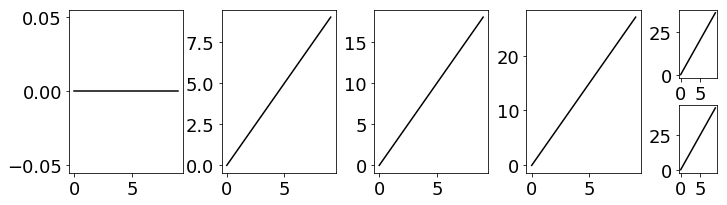

In [246]:
fig, ax = make_subplots(3, 2, True, True);
for i, a in enumerate(ax):
    a.plot(np.arange(10), i*np.arange(10), 'k')
fig.tight_layout()

In [271]:
def recovery_test_multi(K, T, N, kernels, datagen=ramping_dataset, testfuns=[identity_compare], legend=True, corrmap=True, titles=None, xlab='Time', ylab='Correlation'):
    def add_to_axis(ts, corrs, colors, ax):        
        for i in np.arange(len(kernels)):
            plot_ribbon(ts, corrs[i], color=colors[i], ax=ax)
        ax.set(xlim=[0, T-1])
        if not (xlab == None):
            ax.set(xlabel=xlab)
    
    def recovery_corrs(truth, guess):
        return np.diag(1 - cdist(truth, guess, 'correlation'))
    
    corr_tests = []
    for i in np.arange(len(testfuns)):
        x = []
        for j in np.arange(len(kernels)):
            x.append(np.zeros([N, T]))
        corr_tests.append(x)
    
    if corrmap:
        recovered_tcorr_mat = []
        for k in kernels:
            recovered_tcorr_mat.append(np.zeros([T, T]))
    
    for n in np.arange(N):
        next_Y, next_corrs = datagen(K, T)
        for i, k in enumerate(kernels):
            recovered_corrs = tc.timecorr(next_Y, weights_function=k['weights'], weights_params=k['params'])
            for j in np.arange(len(testfuns)):
                a, b = testfuns[j](next_corrs, recovered_corrs)
                corr_tests[j][i][n, :] = recovery_corrs(a, b)
            if corrmap:
                recovered_tcorr_mat[i] = recovered_tcorr_mat[i] + tc.helpers.r2z(1 - cdist(next_corrs, recovered_corrs, 'correlation'))
    if corrmap:
        for i in np.arange(len(kernels)):
            recovered_tcorr_mat[i] = tc.helpers.z2r(np.divide(recovered_tcorr_mat[i], N))
    
    n = 0
    if legend:
        n += 1
    if corrmap:
        n += len(kernels)
    
    colors = sns.cubehelix_palette(n_colors=len(kernels))
    #fig, ax = plt.subplots(nrows=1, ncols=len(testfuns)+n, sharey=True, sharex=False)
    fig, ax = make_subplots(len(testfuns), len(kernels), legend, corrmap)
    
    fig.set_size_inches(10, 2)
    
    ts = np.arange(T)
    for i in np.arange(len(testfuns)):
        add_to_axis(ts, corr_tests[i], colors, ax[i])

    if not (ylab == None):
        ax[0].set(ylabel=ylab)            
    
    if legend:
        hs = []
        for i in np.arange(len(kernels)):
            hs.append(ax[-n].plot(ts, np.ones_like(ts), color=colors[i]))
        ax[-n].legend(list(map(lambda x: x['name'], kernels)), loc='center', frameon=False)
        ax[-n].axis('off')
        for h in hs:
            h[0].set_visible(False)
    
    if corrmap:
        for i in np.arange(len(kernels)):
            sns.heatmap(recovered_tcorr_mat[i], ax=ax[-n+i+1])
            ax[-n+i+1].set_xticks([])
            ax[-n+i+1].set_yticks([])
    
    if not (titles == None):
        if not (type(titles) == list):
            titles = [titles]*(len(ax)-n)
        for i, a in enumerate(ax):
            if i > len(ax) - (n + 1):
                break
            a.set_title(titles[i])

In [323]:
width = 10
delta = {'name': '$\delta$', 'weights': tc.eye_weights, 'params': tc.eye_params}
gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}
laplace = {'name': 'Laplace', 'weights': tc.laplace_weights, 'params': {'scale': width}}
mexican_hat = {'name': 'Mexican hat', 'weights': tc.mexican_hat_weights, 'params': {'sigma': width}}
kernels = [delta, gaussian, laplace, mexican_hat]

K = 100
T = 1000
N = 5

In [327]:
Y, corrs = ramping_dataset(K, T)

In [328]:
recovered_corrs = tc.timecorr(Y, weights_function=laplace['weights'], weights_params=laplace['params'])

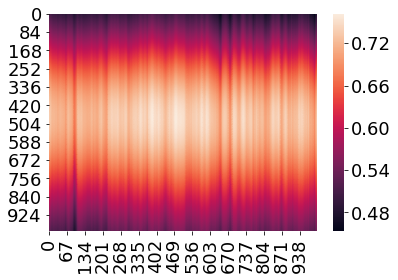

In [329]:
sns.heatmap(1 - cdist(corrs[:, K:], recovered_corrs[:, K:], 'correlation'))

In [280]:
recovery_test_multi(K, T, N, kernels, datagen=ramping_dataset, testfuns=[identity_compare, first_compare, last_compare], titles=['All', 'First', 'Last'])
plt.gcf().savefig(os.path.join(figdir, f'ramping_recovery_{width}.pdf'))

ValueError: operands could not be broadcast together with shapes (500,1,100) (500,10) 

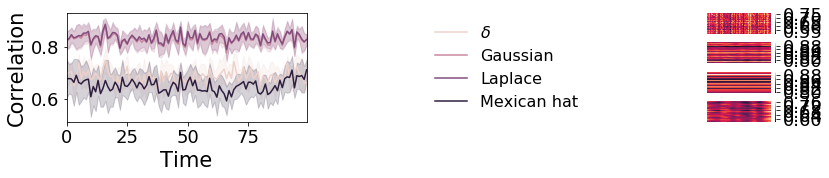

In [274]:
recovery_test_multi(K, T, N, kernels, datagen=random_dataset, testfuns=[identity_compare])
plt.gcf().savefig(os.path.join(figdir, f'random_recovery_{width}.pdf'))